## 0. Carregamento das bibliotecas

In [1]:
# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scikitplot as skplt

# Machine learning 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# balanceamento
from imblearn.under_sampling import RandomUnderSampler

# Grid e Random Search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Metricas de avaliacao
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score


## 1. Carregamento dos dados

Após ter os dados pré-processados, podemos começar a construir nosso modelo.

In [2]:
df = pd.read_csv("covid_11_marco_pre_process.csv", sep=';')

## 2. Treino e teste

Antes de dividirmos nossos dados, vamos verificar o balanceamento dos mesmos.


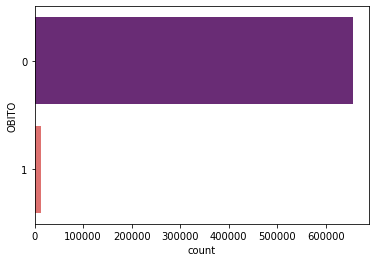

In [3]:
sns.countplot(y='OBITO', data=df, palette="magma");

In [4]:
(df['OBITO'].sum()/df.shape[0]) * 100

2.0997171852101433

Podemos ver que o nosso conjunto de dados está desbalanceado. Mais precisamente, apenas 13.47% dos dados são Óbitos. Se construíssemos um modelo preditivo que classificasse os dados apenas como 0 (Recuperado), teríamos um modelo com 86.53% de acurácia. Queremos evitar esse "comportamento ingênuo".

#### 2.1 Como lidar com dados desbalanceados

Alguns exemplos de situações onde o desbalanceamento é quase certo são problemas de detecção de fraude e diagnóstico médicos - é intuitivo pensar que existem mais transações lícitas que criminosas, ou que o conjunto de pessoas diagnosticadas com câncer é bem menor que o conjunto de pessoas sem a doença.

Ignorar esse fato e treinar um algoritmo em cima do conjunto de dados original, pulando uma etapa intermediária de balanceamento dos dados, pode ter impactos diretos no seu projeto de Data Science.

#### 2.2 Consequências dos dados desbalanceados
Se você está construindo um modelo de machine learning para classificação, por exemplo, a consequência desse desequilíbrio é que o modelo terá uma tendência a dar muitos "alarmes falsos".

Ou seja, na prática ele irá responder muito bem entradas para as classes majoritárias, mas terá um desempenho inferior para as minoriárias.

No exemplo de detecção de fraude com cartões de crédito (onde o número de transações financeiras normais é bem maior que o número de transações fraudulentas), um classificador tenderá a apresentar muitos falsos negativos - uma situação indesejável para um banco, obviamente.

Em um trade-off, seria preferível "errar para mais" e ter uma quantidade maior de falsos positivos. Aliás, aposto que você já teve seu cartão bloqueado preventivamente e teve que ligar no banco para confirmar as últimas compras que havia feito, não é mesmo?!

Teoricamente, um dataset que possua qualquer classe com mais de 50% das entradas já é considerado desbalanceado. No entanto, há situações extremas onde você vai encontrar proporções maiores que 99:1.

Existem várias abordagens para lidar com dados desbalanceados, cada uma com seus prós e contras. Neste artigo, irei mostrar alguns dos métodos mais populares para você incluir desde já no seu arsenal.

#### 2.3 Métodos para lidar com datasets desbalanceados

Há diversas maneiras para atacar o problema de dados desbalanceados, que envolvem desde a construção de algoritmos específicos até a aplicação de algoritmos mais avançados como Recognition-based Learning e Cost-sensitive Learning.

No entanto, uma outra abordagem bem mais simples tem sido amplamente usada (com ótimos resultados), a abordagem *sampling*.

*Sampling* é um pré-processamento que visa minimizar as discrepâncias entre as classes por meio de uma reamostragem do dataset original. Para gerar um conjunto balanceado, são usadas normalmente as seguintes técnicas:

 - Over-sampling: cria novas observações da classe minoritária a partir das informações contidas nos dados originais. Essa geração de novas entradas pode ser feita aleatoriamente com o auxílio de técnicas de clustering ou sinteticamente.

 - Under-sampling: reduz o desbalanceamento do dataset focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.

Além dessas duas técnicas de *sampling*, existem também os advanced sampling methods, como SMOTE e ADASYN, onde instâncias são adicionadas ou removidas adaptativamente.

Para isso, podemos usar abordagens que levam em conta apenas a avaliação do modelo, ou técnicas para rebalanceamento como a **undersampling**, que consiste em reamostrar a classe majoritária (nesse caso, recuperado) e manter apenas uma parte desses pontos.

![under sampling](resampling.png)

#### *tradeoff*
Ao usar um método de reamostragem (por exemplo, para obter tantos dados de ÓBITO quanto de RECUPERADOS), mostramos as proporções erradas das duas classes para o classificador durante o treinamento. O classificador treinado dessa maneira terá uma precisão menor nos dados de teste reais futuros do que o classificador treinado no conjunto de dados inalterado. Na verdade, as verdadeiras proporções das classes são importantes para saber para classificar um novo ponto e essa informação foi perdida ao reamostrar o conjunto de dados. 

- [Handling imbalanced datasets in machine learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)
- [Learning pattern classification tasks with imbalanced data sets](https://ro.uow.edu.au/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1806&context=infopapers)
- [There is No Free Lunch in Data Science](https://www.kdnuggets.com/2019/09/no-free-lunch-data-science.html)

#### 2.3 Divisão treino e teste e balanceamento

Vamos utilizar o `train_test_split` com 30% dos dados para test, e random_state em 42, para replicabilidade do código.

Para balanceamento, utilizaremo do `RandomUnderSampler` do imblearn.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('OBITO', axis=1), df['OBITO'], test_size=0.3, random_state=42)

In [6]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

/home/gustavocrod/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


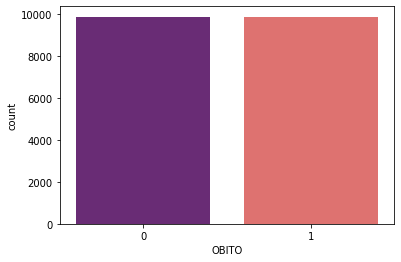

In [7]:
sns.countplot(y_train_rus, palette='magma');

# 3.Algoritmos de aprendizagem de máquina

Vamos utilizar esses algoritmos:

 - Logistic Regression
 - Random Forest
 - Naive Bayes
 - Stochastic Gradient Decent
 - Linear SVC
 - Decision Tree
 - Gradient Boosted Trees

## 3.0 Métricas de avaliação

Como saber se meu modelo previu bem? Como saber se ele prevê bem a classe que queremos (Óbito)? Essas e outras questões podemos entender com as matrizes de confusão.

#### Matriz de confusão

![Matriz de confusao](confusion_matrix.png)

É uma tabela que mostra as frequências de classificação para cada classe do modelo. Ou seja, ela mostra a quantidade de acertos e erros do modelo, e nos mostra as frequências:

 - **Verdadeiro positivo** (*true positive* - TP): ocorre quando no conjunto real, a classe que estamos buscando foi prevista corretamente. Por exemplo, quando o paciente veio a óbito e o modelo previu corretamente que ele veio a falecer. 
 - **Falso positivo** (*false positive* - FP): ocorre quando no conjunto real, a classe que estamos buscando prever foi prevista incorretamente. Exemplo: O paciente foi recuperado, mas o modelo disse que ele veio a óbito
 - **Verdadeiro negativo** (*true negative* - TN): ocorre quando no conjunto real, a classe que não estamos buscando prever foi prevista corretamente. Exemplo: o paciente foi recuperado, e o modelo previu corretamente que ele não veio a óbito.
 - **Falso negativo** (*false negative* - FN): ocorre quando no conjunto real, a classe que não estamos buscando prever foi prevista incorretamente. Por exemplo, quando o paciente era óbito, e o modelo previu que seria recuperado.
 
 
Através desses quatro valores, seremos capazes de calcular os indicadores: Acurácia, Precisão, Revocação (sensibilidade ou *recall*) e F1 Score.

#### Métricas de avaliação decorrentes da matriz de confusão

 **Acurácia**
 Indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;
  
 $acuracia = \frac{TP + TN}{TP + FP + TN + FN} = \frac{predicoes corretas}{todasaspredicoes}$
 
 é uma boa indicação geral de como o modelo performou. Porém, pode haver situações em que ela é enganosa. Por exemplo, na criação de um modelo de identificação de fraudes em cartões de crédito, o número de casos considerados como fraude pode ser bem pequeno em relação ao número de casos considerados legais. Para colocar em números, em uma situação hipotética de 280000 casos legais e 2000 casos fraudulentos, um modelo simplório que simplesmente classifica tudo como legal obteria uma acurácia de 99,3%. Ou seja, você estaria validando como ótimo um modelo que falha em detectar fraudes.
 
 
 **Precisão** (Valor preditivo positivo)
 Entre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas; ( precisão de 1.0 ou 100% significa que não houve nenhum falso positivo.)
 
 $precisao = \frac{TP}{TP + FP}$
  
 A precisão pode ser usada em uma situação em que os Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos. Por exemplo, ao classificar uma ação como um bom investimento, é necessário que o modelo esteja correto, mesmo que acabe classificando bons investimentos como maus investimentos (situação de Falso Negativo) no processo. Ou seja, o modelo deve ser preciso em suas classificações, pois a partir do momento que consideramos um investimento bom quando na verdade ele não é, uma grande perda de dinheiro pode acontecer.
 
 **Sensibilidade/*recall***
 
 Dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas; (recall de 1.0 ou 100% significa que não houve nenhum falso negativo.)
 
 $sensibilidade = \frac{TP}{TP + FN}$
 
 Pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos. Por exemplo, o modelo deve de qualquer maneira encontrar todos os pacientes doentes, mesmo que classifique alguns saudáveis como doentes (situação de Falso Positivo) no processo. Ou seja, o modelo deve ter alto *recall* (sensibilidade), pois classificar pacientes doentes como saudáveis pode ser uma tragédia.
 
 **F1 Score**
 média harmônica entre precisão e sensibilidade.
 
 $f1score = 2 * \frac{precisao * sensibilidade}{precisao + sensibilidade}$
 
 é simplesmente uma maneira de observar somente 1 métrica ao invés de duas (precisão e recall) em alguma situação. É uma média harmônica entre as duas, que está muito mais próxima dos menores valores do que uma média aritmética simples. Ou seja, quando tem-se um F1-Score baixo, é um indicativo de que ou a precisão ou o recall está baixo.

 

In [8]:
def run_model(model, X_train, y_train):
    # fazer as previsões em cima dos dados de teste
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if (isinstance(model, LinearSVC)):
        y_proba=0
        return y_pred, y_proba
    y_proba = model.predict_proba(X_test)
    return y_pred, y_proba

In [9]:
models = [LogisticRegression(max_iter=1000), 
          DecisionTreeClassifier(), 
          KNeighborsClassifier(n_neighbors = 5), 
          GaussianNB(), 
          LinearSVC(), 
          RandomForestClassifier(), 
          MLPClassifier(),
          XGBClassifier()]

verbose_models = ['Regressão logística', 'Árvore de decisão', 'KNN', 
                  'Naive Bayes Gaussiano', 'Linear SVM', 'Floresta aleatória', 
                  'Multilayer perceptron', 'XGBoost']

accuracy_dict = {}
roc_auc_dict = {}
precision_dict = {}
recall_dict = {}
f1_score_dict = {}
for name, model in zip(verbose_models, models):
    y_pred, y_proba = run_model(model, X_train, y_train)
    accuracy_dict[name] = accuracy_score(y_test, y_pred)
    roc_auc_dict[name] = roc_auc_score(y_test, y_pred)
    precision_dict[name] = precision_score(y_test, y_pred) 
    recall_dict[name] = recall_score(y_test, y_pred)
    f1_score_dict[name] = f1_score(y_test, y_pred)

/home/gustavocrod/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/gustavocrod/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
metrics = pd.DataFrame.from_dict(accuracy_dict, orient='index', columns=['Acurácia'])
metrics = metrics.join(pd.DataFrame.from_dict(roc_auc_dict, orient='index', columns=['ROC AUC']))
metrics = metrics.join(pd.DataFrame.from_dict(precision_dict, orient='index', columns=['Precisão']))
metrics = metrics.join(pd.DataFrame.from_dict(recall_dict, orient='index', columns=['Sensibilidade']))
metrics = metrics.join(pd.DataFrame.from_dict(f1_score_dict, orient='index', columns=['F1-Score']))

In [11]:
metrics

,Acurácia,ROC AUC,Precisão,Sensibilidade,F1-Score
Regressão logística,0.980182,0.632749,0.550753,0.270193,0.362532
Árvore de decisão,0.980346,0.619191,0.567522,0.242316,0.339623
KNN,0.977891,0.679850,0.462366,0.368835,0.410338
Naive Bayes Gaussiano,0.946658,0.828066,0.237449,0.704313,0.355160
Linear SVM,0.979655,0.562173,0.553702,0.126519,0.205974
Floresta aleatória,0.980366,0.624798,0.565287,0.253753,0.350271
Multilayer perceptron,0.980395,0.631343,0.563317,0.267096,0.362373
XGBoost,0.980460,0.626479,0.569995,0.257088,0.354351


In [12]:
metrics.index.rename('Modelo', inplace=True)
metrics.reset_index(inplace=True)
df = metrics.melt('Modelo', var_name='Métrica',  value_name='Score')

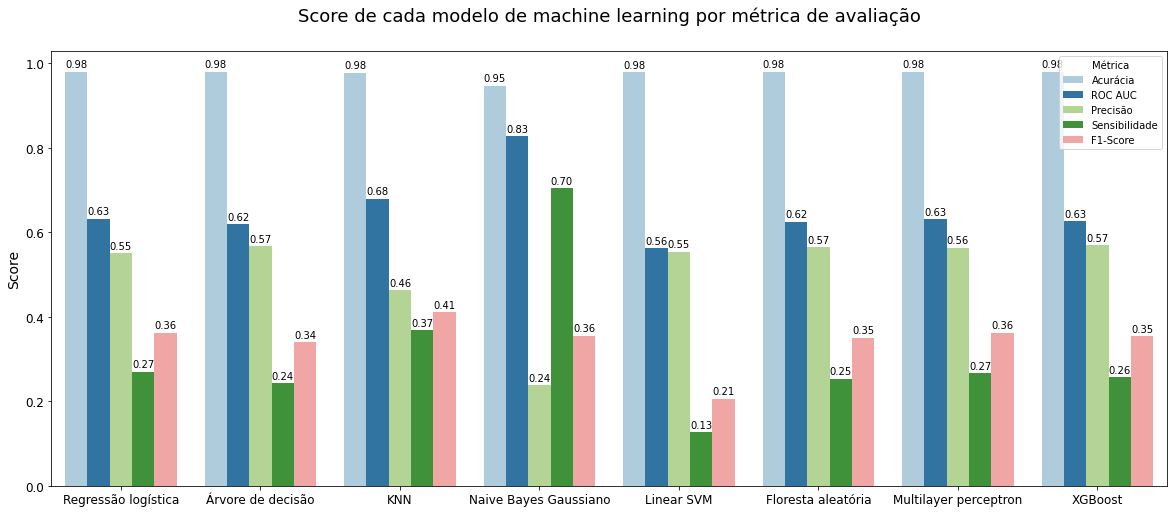

In [13]:
plt.rc('figure', figsize=(20, 8))
ax = sns.barplot(x='Modelo', y='Score', hue='Métrica', data=df, palette='Paired')

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2 # divide por 2 pra ficar no meio
            _y = p.get_y() + p.get_height()+ 0.01 # mais 0.01 pra nao ficar colado na altura da barra
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=10, color='black',) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
show_values_on_bars(ax)

ax.set_title('Score de cada modelo de machine learning por métrica de avaliação', fontsize=18, pad=30);
ax.set_ylabel('Score', fontsize=14)
ax.set_xlabel('')

ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0);

In [14]:
models = [LogisticRegression(max_iter=1000), 
          DecisionTreeClassifier(), 
          KNeighborsClassifier(n_neighbors = 5), 
          GaussianNB(), 
          LinearSVC(), 
          RandomForestClassifier(), 
          MLPClassifier(),
          XGBClassifier()]

verbose_models = ['Regressão logística', 'Árvore de decisão', 'KNN', 
                  'Naive Bayes Gaussiano', 'Linear SVM', 'Floresta aleatória', 
                  'Multilayer perceptron', 'XGBoost']

accuracy_dict = {}
roc_auc_dict = {}
precision_dict = {}
recall_dict = {}
f1_score_dict = {}
for name, model in zip(verbose_models, models):
    y_pred, y_proba = run_model(model, X_train_rus, y_train_rus)
    accuracy_dict[name] = accuracy_score(y_test, y_pred)
    roc_auc_dict[name] = roc_auc_score(y_test, y_pred)
    precision_dict[name] = precision_score(y_test, y_pred) 
    recall_dict[name] = recall_score(y_test, y_pred)
    f1_score_dict[name] = f1_score(y_test, y_pred)

/home/gustavocrod/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/gustavocrod/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:
metrics = pd.DataFrame.from_dict(accuracy_dict, orient='index', columns=['Acurácia'])
metrics = metrics.join(pd.DataFrame.from_dict(roc_auc_dict, orient='index', columns=['ROC AUC']))
metrics = metrics.join(pd.DataFrame.from_dict(precision_dict, orient='index', columns=['Precisão']))
metrics = metrics.join(pd.DataFrame.from_dict(recall_dict, orient='index', columns=['Sensibilidade']))
metrics = metrics.join(pd.DataFrame.from_dict(f1_score_dict, orient='index', columns=['F1-Score']))

In [16]:
metrics

,Acurácia,ROC AUC,Precisão,Sensibilidade,F1-Score
Regressão logística,0.915037,0.915455,0.186711,0.915892,0.310188
Árvore de decisão,0.897817,0.915524,0.161950,0.934000,0.276037
KNN,0.936669,0.887792,0.225547,0.836788,0.355322
Naive Bayes Gaussiano,0.942851,0.827172,0.224061,0.706457,0.340218
Linear SVM,0.926954,0.913612,0.209150,0.899690,0.339400
Floresta aleatória,0.897713,0.915703,0.161865,0.934477,0.275935
Multilayer perceptron,0.925661,0.914935,0.206726,0.903741,0.336483
XGBoost,0.897798,0.915863,0.162007,0.934715,0.276151


In [17]:
metrics.index.rename('Modelo', inplace=True)
metrics.reset_index(inplace=True)
df = metrics.melt('Modelo', var_name='Métrica',  value_name='Score')

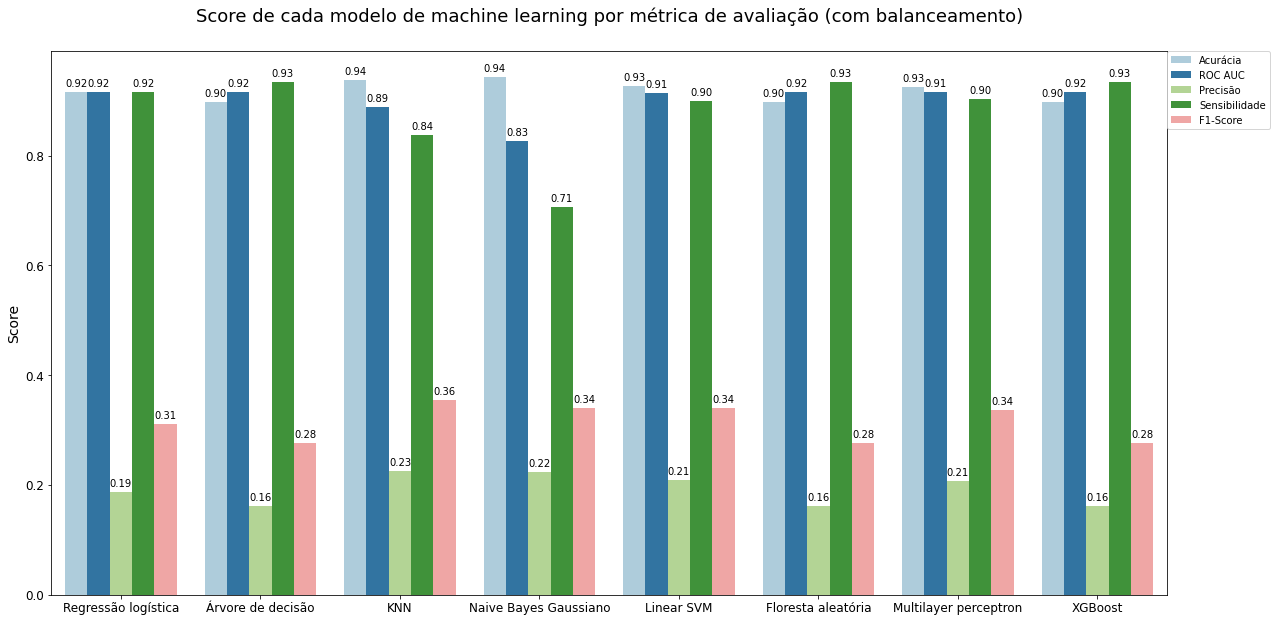

In [26]:
plt.rc('figure', figsize=(20, 10))
ax = sns.barplot(x='Modelo', y='Score', hue='Métrica', data=df, palette='Paired')

        
show_values_on_bars(ax)

ax.set_title('Score de cada modelo de machine learning por métrica de avaliação (com balanceamento)', fontsize=18, pad=30);
ax.set_ylabel('Score', fontsize=14)
ax.set_xlabel('')

ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0);